In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import numpy as ny
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import matplotlib.pyplot as plt

In [2]:
#Pull the .env file into the current directory
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Establish base amounts for this example

In [38]:
# The monthly amount for the member's household income
monthly_income = 12000

In [39]:
# Set the current number of coins for each cryptocurrency asset held in the portfolio.
btc_coins = 1.2
eth_coins = 5.3

## Part 1: Evaluate the Cryptocurrency Wallet by Using the Requests Library

#### Review the endpoint URLs for the API calls to Free Crypto API in order to get the current pricing information for both BTC and ETH.

In [5]:
# The Free Crypto API Call endpoint URLs for the held cryptocurrency assets
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

#### Use the Requests library to get the current price (in US dollars) of Bitcoin (BTC)by using the API endpoints that the starter code supplied.

In [6]:
# Using the Python requests library, make an API call to access the current price of BTC
btc_response = requests.get(btc_url).json()

# Use the json.dumps function to review response data 
# Set the indent and sort_keys parameters to make the response object readable
print(json.dumps(btc_response, indent=3, sort_keys=True))

{
   "data": {
      "1": {
         "circulating_supply": 18879056,
         "id": 1,
         "last_updated": 1637469268,
         "max_supply": 21000000,
         "name": "Bitcoin",
         "quotes": {
            "USD": {
               "market_cap": 1117528489074,
               "percent_change_1h": -0.0633476343301099,
               "percent_change_24h": 0.796350966116545,
               "percent_change_7d": -8.48566245185324,
               "percentage_change_1h": -0.0633476343301099,
               "percentage_change_24h": 0.796350966116545,
               "percentage_change_7d": -8.48566245185324,
               "price": 59173.0,
               "volume_24h": 27340501439
            }
         },
         "rank": 1,
         "symbol": "BTC",
         "total_supply": 18879056,
         "website_slug": "bitcoin"
      }
   },
   "metadata": {
      "error": null,
      "num_cryptocurrencies": 3105,
      "timestamp": 1637469268
   }
}


#### Navigate the JSON response object to access the current price of each coin, and store each in a variable.

In [7]:
# Navigate the BTC response object to access the current price of BTC
btc_price = btc_response["data"]['1']['quotes']['USD']["price"]

# Print the current price of BTC
btc_price

59173.0

#### Repeat for ETH

In [8]:
# Using the Python requests library, make an API call to access the current price ETH
eth_response = requests.get(eth_url).json()

# Use the json.dumps function to review the response data from the API call
# Use the indent and sort_keys parameters to make the response object readable
print(json.dumps(eth_response, indent=3, sort_keys=True))

{
   "data": {
      "1027": {
         "circulating_supply": 118426210,
         "id": 1027,
         "last_updated": 1637469160,
         "max_supply": 0,
         "name": "Ethereum",
         "quotes": {
            "USD": {
               "market_cap": 517009236301,
               "percent_change_1h": -0.497992368366455,
               "percent_change_24h": 1.73969152710999,
               "percent_change_7d": -6.4466507718475,
               "percentage_change_1h": -0.497992368366455,
               "percentage_change_24h": 1.73969152710999,
               "percentage_change_7d": -6.4466507718475,
               "price": 4365.67,
               "volume_24h": 15257765898
            }
         },
         "rank": 2,
         "symbol": "ETH",
         "total_supply": 118426210,
         "website_slug": "ethereum"
      }
   },
   "metadata": {
      "error": null,
      "num_cryptocurrencies": 3105,
      "timestamp": 1637469160
   }
}


In [9]:
# Navigate the ETH response object to access the current price of ETH
eth_price = eth_response['data']['1027']['quotes']['USD']['price']

# Print the current price of ETH
eth_price

4365.67

### Calculate the value, in US dollars, of the current amount of each cryptocurrency and of the entire cryptocurrency wallet.

In [10]:
# Build a Series to hold our BTC and ETH values
btc_value=pd.Series(data=[btc_coins, btc_price, (btc_coins*btc_price)], index= ['coins', 'curr_mkt_price', 'total value'])
type(btc_value)

pandas.core.series.Series

In [11]:
# Compute the current value of the BTC holding 
eth_value=pd.Series(data=[eth_coins, eth_price, (eth_coins*eth_price)], index= ['coins', 'curr_mkt_price', 'total value'])
eth_value

coins                 5.300
curr_mkt_price     4365.670
total value       23138.051
dtype: float64

In [12]:
# Compute the total value of the cryptocurrency wallet
# Add the value of the BTC holding to the value of the ETH holding
crypto_value= pd.concat([btc_value , eth_value],axis=1)

# Print current cryptocurrency wallet balance
crypto_value= crypto_value.rename(columns={0:'btc',1:'eth'})
crypto_value=crypto_value.transpose()
crypto_value

,coins,curr_mkt_price,total value
btc,1.2,59173.00,71007.600
eth,5.3,4365.67,23138.051


In [13]:
total_crypto_wallet=crypto_value['total value'].sum()
total_crypto_wallet

94145.65099999998

### Evaluate the Stock and Bond Holdings by Using the Alpaca SDK


#### Review the total number of shares held in both (SPY) and (AGG).

In [14]:
# Current amount of shares held in both the stock (SPY) and bond (AGG) portion of the portfolio.
spy_shares = 110
agg_shares = 200

#### Set the variables for the Alpaca API and secret keys. Using the Alpaca SDK, create the Alpaca `tradeapi.REST` object. In this object, include the parameters for the Alpaca API key, the secret key, and the version number.

In [15]:
# Set the variables for the Alpaca API and secret keys
alpaca_key=os.getenv('alpaca_key')
alpaca_secret_key=os.getenv('alpaca_secret_key')

# Create the Alpaca tradeapi.REST object. Pass in as parameters the API key, secret key, and version number.
alpaca = tradeapi.REST(
alpaca_key,
alpaca_secret_key,
api_version='v2')

In [17]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers= ["SPY","AGG"]

# Set timeframe to 1D 
timeframe="1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday to provide the closing price of the previous trading day
start_date=pd.Timestamp("2021-11-12",tz="America/New_York").isoformat()
end_date=pd.Timestamp("2021-11-12",tz="America/New_York").isoformat()

In [18]:
# Use the Alpaca get_barset function to get closing prices the portfolio. don't forget to add '.df' at the end.
df_portfolio=alpaca.get_barset(
tickers,
timeframe,
start=start_date,
end=end_date,
).df

# Review the Alpaca DataFrame
df_portfolio.head()

AGG                                       SPY  \
                            open     high     low   close   volume    open   
time                                                                         
2021-11-12 00:00:00-05:00  114.5  114.585  114.26  114.33  4398727  465.12   

                                                             
                             high     low   close    volume  
time                                                         
2021-11-12 00:00:00-05:00  467.86  464.11  467.26  44677612

In [19]:
#Create an empty DataFrame for closing prices
closing_prices_df = pd.DataFrame()

# Get the closing prices of AGG and SPY
closing_prices_df['AGG'] = df_portfolio["AGG"]['close']
closing_prices_df['SPY'] = df_portfolio["SPY"]['close']

# Drop the time component of the date
closing_prices_df.index = closing_prices_df.index.date

# Check your work
closing_prices_df.head()

,AGG,SPY
2021-11-12,114.33,467.26


In [21]:
### Add the number of shares variable to the data frame
### Calculate the total value of each position in the DataFrame
new_sb_closing_prices_df=closing_prices_df.transpose()
new_sb_closing_prices_df['shares']=[agg_shares,spy_shares]
new_sb_closing_prices_df.columns=['mkt price', 'shares']
new_sb_closing_prices_df.head()

,mkt price,shares
AGG,114.33,200
SPY,467.26,110


In [22]:
# Calculate the current value of the stock portion of the portfolio
new_sb_closing_prices_df['total value']=new_sb_closing_prices_df['mkt price']*new_sb_closing_prices_df['shares']
new_sb_closing_prices_df

,mkt price,shares,total value
AGG,114.33,200,22866.0
SPY,467.26,110,51398.6


In [24]:
# Calculate the total value of the stock and bond portion of the portfolio
stocks_bonds_value= new_sb_closing_prices_df['total value'].sum()

# Print the current balance of the stock and bond portion of the portfolio
stocks_bonds_value

74264.6

In [25]:
# Remember the crypto_value
total_crypto_wallet

94145.65099999998

In [26]:
# Calculate the total value of the member's entire portfolio
portfolio=stocks_bonds_value+total_crypto_wallet
portfolio

168410.251

### Evaluate the Emergency Fund

In [27]:
# Consolidate financial assets data 
new_sb_closing_prices_df=new_sb_closing_prices_df.rename(columns={'shares':'units'})
new_sb_closing_prices_df=new_sb_closing_prices_df[['units','mkt price', 'total value']]
new_sb_closing_prices_df


,units,mkt price,total value
AGG,200,114.33,22866.0
SPY,110,467.26,51398.6


In [28]:
# Review the Python list savings_data
crypto_value=crypto_value.rename(columns={'coins':'units', 'curr_mkt_price':'mkt price'})
crypto_value

,units,mkt price,total value
btc,1.2,59173.00,71007.600
eth,5.3,4365.67,23138.051


In [30]:
# Take a look at your complete portfolio
total_portfolio=pd.concat([new_sb_closing_prices_df, crypto_value])
total_portfolio

,units,mkt price,total value
AGG,200.0,114.33,22866.000
SPY,110.0,467.26,51398.600
btc,1.2,59173.00,71007.600
eth,5.3,4365.67,23138.051


#### Step 3: Use the `savings_df` DataFrame to plot a pie chart that visualizes the composition of the member’s portfolio. The y-axis of the pie chart uses `amount`. Be sure to add a title.

<AxesSubplot:title={'center':'Members Total Portfolio'}, ylabel='total value'>

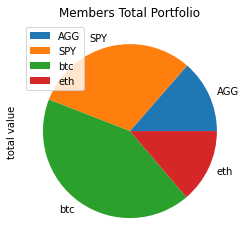

In [31]:
# Plot the total value of the member's portfolio (crypto and stock/bond) in a pie chart
total_portfolio.plot(kind="pie", y='total value', title="Members Total Portfolio")

#### Using Python, determine if the current portfolio has enough to create an emergency fund as part of the member’s financial plan. Ideally, an emergency fund should equal to three times the member’s monthly income. To do this, implement the following steps:

##### Create a variable named `emergency_fund_value`, and set it equal to three times the value of the member’s `monthly_income` of 12000.

In [34]:
# Create a variable named emergency_fund_value
emergency_fund_value = monthly_income * 3
emergency_fund_value

36000

In [35]:
total_portfolio_value = total_portfolio['total value'].sum()
total_portfolio_value

168410.25100000002

##### Create a series of three if statements to determine if the member’s total portfolio is large enough to fund the emergency portfolio:

* If the total portfolio value is greater than the emergency fund value, display a message congratulating the member for having enough money in this fund.

* Else if the total portfolio value is equal to the emergency fund value, display a message congratulating the member on reaching this important financial goal.

* Else the total portfolio is less than the emergency fund value, so display a message showing how many dollars away the member is from reaching the goal. (Subtract the total portfolio value from the emergency fund value.)

In [37]:
# Evaluate the possibility of creating an emergency fund with 3 conditions:
if total_portfolio_value > emergency_fund_value:
    print('Congratulations, you are on the right track!')
elif total_portfolio_value==emergency_fund_value:  
    print('Great, you made it!')
else:
    print(f"you're this {emergency_fund_value-total_portfolio_value} far away")

Congratulations, you are on the right track!


### Part 2: Create a Financial Planner for Retirement and Monte Carlo Simulation

#### Step 1: Make an API call via the Alpaca SDK to get 3 years of historical closing prices for a traditional 60/40 portfolio split: 60% stocks (SPY) and 40% bonds (AGG).

In [40]:
# Set start and end dates of 3 years back from your current date
end_date
new_start_date=pd.Timestamp("2018-11-12",tz="America/New_York").isoformat()


# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows=1000

In [41]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
new_prices_df = alpaca.get_barset(
  tickers,
  timeframe,
  start=new_start_date,
  end=end_date,
  limit=limit_rows
).df


# Display both the first and last five rows of the DataFrame
new_prices_df

AGG                                       \
                             open     high       low    close   volume   
time                                                                     
2018-11-12 00:00:00-05:00  104.31  104.350  104.2500  104.310  2142786   
2018-11-13 00:00:00-05:00  104.30  104.370  104.2131  104.350  2772430   
2018-11-14 00:00:00-05:00  104.22  104.500  104.2000  104.360  3170153   
2018-11-15 00:00:00-05:00  104.48  104.510  104.3101  104.480  3694888   
2018-11-16 00:00:00-05:00  104.55  104.710  104.5100  104.655  3277200   
...                           ...      ...       ...      ...      ...   
2021-11-08 00:00:00-05:00  115.14  115.150  114.9500  115.010  4696293   
2021-11-09 00:00:00-05:00  115.38  115.500  115.2900  115.330  6955738   
2021-11-10 00:00:00-05:00  115.11  115.140  114.3950  114.510  8821475   
2021-11-11 00:00:00-05:00  114.51  114.570  114.3000  114.340  3105027   
2021-11-12 00:00:00-05:00  114.50  114.585  114.2600  114.330  4398727   

                              SPY                                        
                             open     high       low   close     volume  
time                                                                     
2018-11-12 00:00:00-05:00  277.15  277.460  271.9900  272.49   78678065  
2018-11-13 00:00:00-05:00  273.09  275.325  271.2500  272.06   78846402  
2018-11-14 00:00:00-05:00  274.16  274.610  268.4499  270.13  113944238  
2018-11-15 00:00:00-05:00  268.78  273.540  267.0102  273.07  118131123  
2018-11-16 00:00:00-05:00  271.79  276.000  271.2100  273.68  107341090  
...                           ...      ...       ...     ...        ...  
2021-11-08 00:00:00-05:00  469.70  470.230  468.2031  468.97   38945705  
2021-11-09 00:00:00-05:00  469.32  469.570  465.8800  467.38   47198095  
2021-11-10 00:00:00-05:00  465.58  467.380  462.0400  463.63   63500032  
2021-11-11 00:00:00-05:00  465.21  465.290  463.7500  463.81   31757893  
2021-11-12 00:00:00-05:00  465.12  467.860  464.1100  467.26   44677612  

[757 rows x 10 columns]

#### Step 2: Run a Monte Carlo simulation of 500 samples and 30 years for the 60/40 portfolio, and then plot the results.

In [42]:
# Create an empty `closing_prices_df` DataFrame using Pandas
new_closing_prices_df = pd.DataFrame()

# Populate the `closing_prices_df` DataFrame by accessing the `close` column
# from the `prices_df` DataFrame for both KO and TSLA .
new_closing_prices_df["AGG"] = new_prices_df["AGG"]["close"]
new_closing_prices_df["SPY"] = new_prices_df["SPY"]["close"]

# Update the index for the `closing_prices_df` DataFrame
# to retain only the `date` component.
new_closing_prices_df.index = new_closing_prices_df.index.date

# Compute the `daily_returns_df` DataFrame by chaining
# the pct_change function with the dropna function.
new_daily_returns_df = new_closing_prices_df.pct_change().dropna()

# Display both the head and tail of the `daily_returns_df` DataFrame
display(new_daily_returns_df.head())
display(new_daily_returns_df.tail())

,AGG,SPY
2018-11-13,0.000383,-0.001578
2018-11-14,0.000096,-0.007094
2018-11-15,0.001150,0.010884
2018-11-16,0.001675,0.002234
2018-11-19,0.000048,-0.016808


,AGG,SPY
2021-11-08,-0.001996,0.001025
2021-11-09,0.002782,-0.003390
2021-11-10,-0.007110,-0.008023
2021-11-11,-0.001485,0.000388
2021-11-12,-0.000087,0.007438


In [43]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_thirty_year = MCSimulation(
  portfolio_data = new_prices_df,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*30
)

# Review the simulation input data
MC_thirty_year


In [44]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999461,1.007180,1.006174,0.999665,0.989746,0.989928,1.004550,0.999303,1.007595,1.001493,...,0.998256,0.994583,0.990898,1.000106,1.002460,0.997090,1.001610,0.997570,0.993347,1.006209
2,0.985741,1.022494,1.004492,1.005401,0.982288,0.981517,1.007704,1.001709,1.027839,0.996033,...,0.996243,0.984988,0.983279,0.990734,1.013670,0.989316,0.996563,0.996694,1.001949,1.003987
3,0.980264,1.010736,1.011377,1.015174,0.978425,0.998349,0.994136,1.001376,1.023886,0.999317,...,0.993840,0.990953,0.996370,0.979579,1.008376,0.989676,0.995795,0.998798,1.008271,1.010341
4,0.991141,1.042951,1.025218,1.031182,0.973208,0.986998,0.995589,0.998927,1.025372,0.994771,...,0.996058,0.991133,1.012381,0.987820,1.019132,1.005019,0.995087,0.999553,1.015201,0.999168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,63.136766,171.764463,19.856279,152.882315,16.363781,42.547573,182.255683,34.078302,39.352417,22.692935,...,100.769107,31.475367,64.094103,48.457703,38.836861,50.390477,59.294861,17.708245,82.155422,30.950402
7557,62.436175,173.055727,19.626088,155.544182,16.257595,42.635924,181.319381,34.066288,39.214047,22.608661,...,101.486418,31.736106,64.016349,48.932894,38.947223,50.714843,59.350050,17.696654,81.957887,31.782188
7558,62.988912,172.047372,19.442010,158.371211,16.448459,42.320779,184.096060,33.478736,38.674459,22.501909,...,101.002363,32.031040,64.229936,48.562855,38.655810,50.392955,60.234903,17.644191,81.992681,32.102720
7559,64.084110,171.038292,19.473866,159.263893,16.441124,42.129486,187.330502,33.358781,38.474226,22.618108,...,102.129518,32.328951,63.758357,48.456931,38.616684,50.357140,60.322048,17.425932,80.772015,32.574027


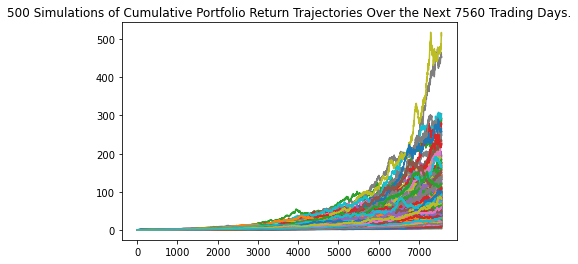

In [58]:
# Visualize the 30-year Monte Carlo simulation by creating an overlay line plot
MC_sim_line_plot = MC_thirty_year.plot_simulation()


#### Step 3: Plot the probability distribution of the Monte Carlo simulation.

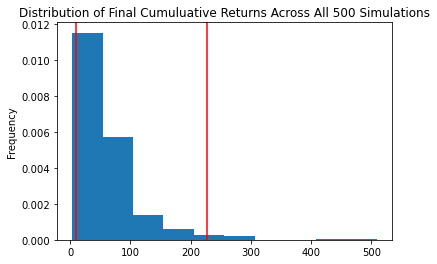

In [46]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation by plotting a histogram
MC_sim_dist_plot = MC_thirty_year.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [47]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_statistics = MC_thirty_year.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
MC_summary_statistics

count           500.000000
mean             61.766001
std              56.541739
min               3.473998
25%              26.438336
50%              45.927081
75%              77.686226
max             508.705542
95% CI Lower     10.611294
95% CI Upper    226.771827
Name: 7560, dtype: float64

### Analyze the Retirement Portfolio Forecasts


In [59]:
# Print the current balance of the stock and bond portion of the members portfolio
print(new_sb_closing_prices_df)
stocks_bonds_value

     units  mkt price  total value
AGG    200     114.33      22866.0
SPY    110     467.26      51398.6


74264.6

In [60]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_thirty_cumulative_return = MC_summary_statistics[8] * stocks_bonds_value
ci_upper_thirty_cumulative_return = MC_summary_statistics[9] * stocks_bonds_value

# Print the result of your calculations
print(ci_lower_thirty_cumulative_return)
print(ci_upper_thirty_cumulative_return)

788043.5150541519
16841118.99393755


## What Are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?

In [75]:
print(f'The lower bound is ${ci_lower_thirty_cumulative_return:.2f}, and the upper bound is ${ci_upper_thirty_cumulative_return:.2f} with a 95% confidence')

The lower bound is $788043.52, and the upper bound is $16841118.99 with a 95% confidence


### Forecast Cumulative Returns in 10 Years

- Forecast the cumulative returns for 10 years from now. Because of the shortened investment horizon (30 years to 10 years), the portfolio needs to invest more heavily in the riskier asset&mdash;that is, stock&mdash;to help accumulate wealth for retirement. 

- Adjust the weights of the retirement portfolio so that the composition for the Monte Carlo simulation consists of 20% bonds and 80% stocks. 

- Run the simulation over 500 samples, and use the same data that the API call to Alpaca generated.


In [50]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split 20% to AGG and 80% to SPY.
# Run 500 samples.
MC_ten_year = MCSimulation(
  portfolio_data = new_prices_df,
  weights = [.20,.80],
  num_simulation = 500,
  num_trading_days = 252*10
)

# Review the simulation input data
MC_ten_year

In [51]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993917,0.993598,1.004715,1.000362,1.007628,1.002647,0.988200,1.011414,1.000333,0.990634,...,1.002866,1.008403,0.990464,0.992055,0.992586,1.001591,0.984248,0.997624,1.006123,1.003206
2,0.974578,1.010165,1.011696,0.998936,0.988374,0.986922,0.985866,0.997981,1.007981,0.968743,...,0.999192,0.996486,0.982239,0.994147,1.002756,0.999333,0.997221,0.988048,0.996641,0.996964
3,0.958501,1.018282,0.997405,0.982808,1.014691,0.984308,0.992699,1.003735,1.011112,0.956360,...,1.011127,1.003606,0.983781,0.991422,0.987801,1.000467,0.991753,0.997517,0.982486,1.002883
4,0.992918,1.039058,0.994891,0.982038,1.016060,0.987661,0.994896,1.021381,0.997531,0.930906,...,1.023493,1.021372,0.995234,0.972858,0.989395,1.013983,0.993436,1.011303,0.981013,1.011334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.753573,4.962513,4.071453,3.780033,7.329248,3.001864,3.420564,11.961838,7.480283,4.169714,...,3.792387,4.250422,10.340577,4.210153,5.151230,14.908445,4.493006,11.232945,1.812335,5.412288
2517,1.775053,5.006306,4.104329,3.812152,7.275490,2.946768,3.439437,12.182161,7.571106,4.194894,...,3.829006,4.285407,10.328552,4.127332,4.957984,14.978157,4.534010,11.355266,1.783215,5.448173
2518,1.762550,5.035614,4.052157,3.806060,7.242577,2.928195,3.395408,12.270133,7.482147,4.254621,...,3.816185,4.323360,10.262437,4.093002,4.873851,14.941686,4.623289,11.611881,1.788458,5.435631
2519,1.771299,4.989804,4.136426,3.767453,7.232676,2.983648,3.391525,12.390160,7.478879,4.238801,...,3.800428,4.373550,10.525675,4.081814,4.839789,14.973085,4.658749,11.500089,1.833124,5.559952


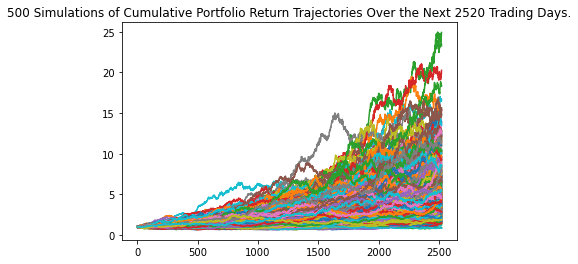

In [52]:
# Visualize the 10-year Monte Carlo simulation by creating an overlay line plot
MC_sim_line_plot = MC_ten_year.plot_simulation()

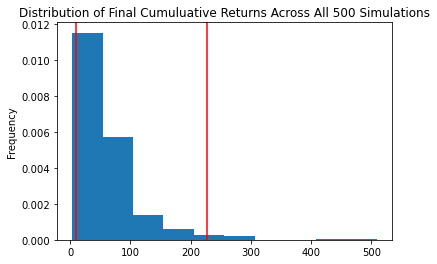

In [53]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation by plotting a histogram
MC_sim_dist_plot = MC_thirty_year.plot_distribution()

In [54]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_ten_summary_statistics = MC_ten_year.summarize_cumulative_return()

# Review the 10-year Monte Carlo summary statistics
MC_ten_summary_statistics

count           500.000000
mean              5.664675
std               3.386158
min               0.859577
25%               3.325256
50%               4.804462
75%               7.090894
max              24.910457
95% CI Lower      1.514211
95% CI Upper     14.307476
Name: 2520, dtype: float64

In [55]:
# Print the current balance of the stock and bond portion of the members portfolio
print(new_sb_closing_prices_df)
stocks_bonds_value

     units  mkt price  total value
AGG    200     114.33      22866.0
SPY    110     467.26      51398.6


74264.6

In [69]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = MC_ten_summary_statistics[8] * stocks_bonds_value
ci_upper_ten_cumulative_return = MC_ten_summary_statistics[9] * stocks_bonds_value

# Print the result of your calculations
print(ci_lower_ten_cumulative_return)
print(ci_upper_ten_cumulative_return)


112452.30696199457
1062539.0053226468


#### Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the new Monte Carlo simulation, what are the lower and upper bounds for the expected value of the portfolio (with the new weights) with a 95% confidence interval?

In [72]:
print(f'Within a 95% confidence level, the lower bound of expected portfolio value is ${ci_lower_ten_cumulative_return:.2f}, and the upper bound is ${ci_upper_ten_cumulative_return:.2f}.')

Within a 95% confidence level, the lower bound of expected portfolio value is $112452.31, and the upper bound is $1062539.01.


#### Will weighting the portfolio more heavily toward stocks allow the credit union members to retire after only 10 years?

In [74]:
print("No, there is not enough of an impact and the credit union members will still need to work. The 80% weighting of a portfolio to SPY will not impact the portfolio enough. It will be better for the investor to stay in the market longer as shown by the large gap in upper bounds between the 10-year and the 30-year")

No, there is not enough of an impact and the credit union members will still need to work. The 80% weighting of a portfolio to SPY will not impact the portfolio enough. It will be better for the investor to stay in the market longer as shown by the large gap in upper bounds between the 10-year and the 30-year
